In [5]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

%matplotlib inline

In [6]:
swissprot = pd.read_parquet('/projects/bpms/pstjohn/swissprot/parsed_swissprot_uniref_clusters.parquet')

In [7]:
dev = pd.read_csv('/projects/bpms/pstjohn/split_uniref100/dev_uniref50.csv', header=None)
test = pd.read_csv('/projects/bpms/pstjohn/split_uniref100/test_uniref50.csv', header=None)

In [8]:
swissprot['Set'] = 'train'
swissprot.loc[swissprot['UniRef50 ID'].isin(dev[0]), 'Set'] = 'dev'
swissprot.loc[swissprot['UniRef50 ID'].isin(test[0]), 'Set'] = 'test'
swissprot.Set.value_counts()

train    561327
test        127
dev         114
Name: Set, dtype: int64

In [9]:
go_terms = pd.read_parquet('/projects/bpms/pstjohn/swissprot/swissprot_quickgo.parquet')

In [ ]:
go_terms['GO EVIDENCE CODE'].value_counts()

In [ ]:
len(go_terms['GENE PRODUCT ID'].unique())

In [ ]:
import networkx as nx
import itertools
import gzip
import re

In [13]:
def parse_group(group):
    out =  {}
    out['type'] = group[0]
    out['is_a'] = []
    out['relationship'] = []
    
    for line in group[1:]:
        key, val = line.split(': ', 1)
        
        # Strip out GO names
        if '!' in val:
            val = re.sub('\ !\ .*$', '', val)
        
        if key == 'relationship':
            val = val.split(' ')
            
        # Convert to lists of GO names
        if key not in out:
            out[key] = val
        else:
            try:
                out[key] += [val]
            except TypeError:
                out[key] = [out[key], val]

    return out

add_rels = False


class Ontology(object):
    def __init__(self, obo_file, with_relationships=False):
        """ Class to parse an .obo.gz file containing a gene ontology description,
        and build a networkx graph. Allows for propogating scores and annotations
        to descendent nodes"""
        
        self.G = self.create_graph(obo_file, with_relationships)

    
    def create_graph(self, obo_file, with_relationships):

        G = nx.DiGraph()
        
        with gzip.open(obo_file, mode='rt') as f:


            groups = ([l.strip() for l in g] for k, g in
                      itertools.groupby(f, lambda line: line == '\n'))

            for group in groups:
                data = parse_group(group)

                if ('is_obsolete' in data) or (data['type'] != '[Term]'):
                    continue

                G.add_node(data['id'], name=data.get('name'), namespace=data.get('namespace'))

                for target in data['is_a']:
                    G.add_edge(target, data['id'], type='is_a')

                if with_relationships:
                    for type_, target in data['relationship']:
                        G.add_edge(target, data['id'], type=type_)
        
        for i, (node, data) in enumerate(G.nodes.items()):
            data['index'] = i
        
        return G

    
    def get_ancestor_list(self, terms):
        return set.union(*(nx.ancestors(self.G, term) for term in ontology_list))        
    
    def ancestor_list_to_array(self, terms):
        """ Propogate labels to ancestor nodes """
        ancestors = self.get_ancestor_list(ontology_list)
        arr = np.zeros(self.G.number_of_nodes())
        for term in itertools.chain(ancestors, ontology_list):
            arr[self.G.nodes[term]['index']] = 1

        return arr
    

    def get_term_child_indexes(self, term):
        return sorted([self.G.nodes[term]['index'] for term in
                       itertools.chain([term], nx.descendants(self.G, term))])

    
    def get_descendent_array(self):
        return [self.get_term_child_indexes(node) for node in self.G.nodes]

    
    def get_head_node_indices(self):
        return [self.G.nodes[node]['index'] for node, degree in self.G.in_degree if degree == 0]

In [ ]:
ont = Ontology('go-basic.obo.gz', with_relationships=False)
G = ont.G

In [ ]:
ont.get_head_node_indices()

In [ ]:
G.nodes['GO:0008150']['index']

In [ ]:
ont.ontology_list_to_array(go_terms[go_terms['GENE PRODUCT ID'] == 'A4K2U9']['GO TERM']).sum()

In [ ]:
go_terms.head()

In [ ]:
used_terms.intersection(set([node for node, item in G.nodes.data('is_obsolete') if item]))

In [ ]:
used_terms.difference(set([node for node, item in G.nodes.data('is_obsolete') if not item]))

In [ ]:
G.nodes['GO:2001317']

In [1]:
import sys
sys.path.append('..')

In [251]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [252]:
from bert.go import Ontology

ont = Ontology()

In [254]:
ont.total_nodes

3180

In [241]:
len(ont.to_include)

32372

Also need to 
* 'canconicalize' GO lists: just get unique leaf terms that fully specify the tree
* Get full ancenstry of each GO list

Then, find leaf terms that show up with some minimum frequency; drop annotations with others; find all ancestry nodes in common to new set of leafs and shrink graph

In [219]:
ont.get_descendants('GO:0035792')

{'GO:0035792'}

In [220]:
ont.get_ancestors(go_terms[go_terms['GENE PRODUCT ID'] == 'A2CKF6']['GO TERM'].values)

{'GO:0003674',
 'GO:0005575',
 'GO:0005576',
 'GO:0008150',
 'GO:0009405',
 'GO:0018995',
 'GO:0033643',
 'GO:0035792',
 'GO:0035821',
 'GO:0044419',
 'GO:0090729',
 'GO:0110165'}

In [227]:
ont.termlist_to_array(ont.get_ancestors(go_terms[go_terms['GENE PRODUCT ID'] == 'A2CKF6']['GO TERM'].values)).shape

(32371,)

In [222]:
len(ont.get_descendent_array())

32371

In [223]:
ont.total_nodes

32371

In [141]:
leafs = go_terms.groupby('GENE PRODUCT ID').apply(
    lambda df: pd.Series(list(ont.get_canoconical_terms(df['GO TERM'].values))))

In [145]:
leaf_counts = leafs.value_counts()

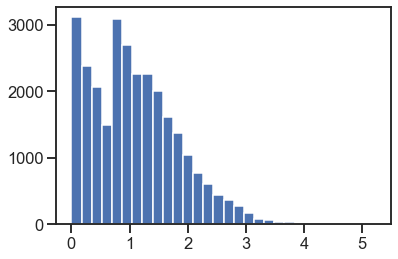

In [146]:
_ = plt.hist(np.log10(leaf_counts), bins=30)

In [147]:
leaf_counts.to_csv('leaf_counts.csv.gz', compression='gzip')

In [148]:
leaf_counts[leaf_counts >= 100]

GO:0005737    172638
GO:0005524     88176
GO:0006412     74247
GO:0005886     69848
GO:0016021     66481
               ...  
GO:0032728       100
GO:0006301       100
GO:0005319       100
GO:0030174       100
GO:0046496       100
Length: 3452, dtype: int64

In [149]:
all_terms = go_terms.groupby('GENE PRODUCT ID').apply(
    lambda df: pd.Series(list(ont.get_ancestor_list(df['GO TERM'].values))))

In [151]:
term_counts = all_terms.value_counts()

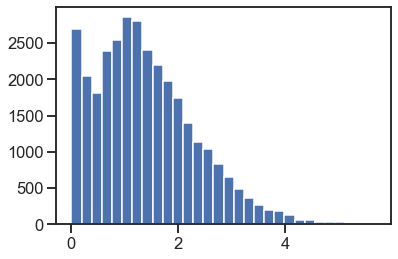

In [153]:
_ = plt.hist(np.log10(term_counts), bins=30)

In [160]:
to_include = set(term_counts[term_counts >= 500].index)

In [163]:
len([node for node in filter(lambda x: x in to_include, ont.G.nodes)])

3181

In [158]:
term_counts.to_csv('term_counts.csv.gz', compression='gzip')

In [228]:
term_counts

GO:0008150    505987
GO:0003674    491998
GO:0009987    434744
GO:0005575    419103
GO:0110165    405783
               ...  
GO:2001002         1
GO:0046904         1
GO:0015471         1
GO:0033777         1
GO:1900742         1
Length: 32372, dtype: int64

In [233]:
self = ont
threshold = 500

In [234]:
to_include = set(term_counts[term_counts >= threshold].index)

for i, (node, data) in enumerate(filter(lambda x: x[0] in to_include,
                                        self.G.nodes.items())):
    data['index'] = i

self.total_nodes = i

In [46]:
ont.get_canoconical_terms(go_terms[go_terms['GENE PRODUCT ID'] == 'A2CKF6']['GO TERM'].values)

{'GO:0003674', 'GO:0033643', 'GO:0044419'}

In [35]:
subgraph = ont.G.subgraph(ont.get_ancestor_list(go_terms[go_terms['GENE PRODUCT ID'] == 'A2CKF6']['GO TERM'].values))
{node for node, degree in subgraph.out_degree if degree == 0}

{'GO:0003674', 'GO:0033643', 'GO:0044419'}

<bound method Graph.subgraph of <networkx.classes.digraph.DiGraph object at 0x7f0a4ad85d10>>